In [6]:
import xgboost
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, f1_score
from scipy.stats import boxcox
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, Booster
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope

In [7]:
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, f1_score, fbeta_score, mean_squared_error
def classification_report_with_scores(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    AUC = roc_auc_score(y_true, y_pred)
    cls_report = classification_report(y_true, y_pred)

    # Append additional metrics to classification report
    cls_report = f'\nAccuracy: {accuracy:.3f}' \
                 f'\nFalse Positive Rate: {fpr:.3f}' \
                 f'\nFalse Negative Rate: {fnr:.3f}' \
                 f'\nPrecision: {precision:.3f}' \
                 f'\nRecall: {recall:.3f}' \
                 f'\nRMSE:{rmse:.3f}' \
                 f'\nF1-Score:{f1:.3f}' \
                 f'\nF2-Score:{f2:.3f}' \
                 f'\nROC_AUC_Score:{AUC:.3f}' + \
                 f'\n{cls_report}'

    return cls_report

In [42]:
X_train_1=pd.read_parquet('X_train_robust_data.gzip.parquet')
X_train_2=pd.read_parquet('X_train_standard_data.gzip.parquet')
X_train_3=pd.read_parquet('X_train_min_max_data.gzip.parquet')
X_train_4=pd.read_parquet('X_train_max_abs_data.gzip.parquet')
X_train_5=pd.read_parquet('X_train_standard_data_pca.gzip.parquet')
X_train_6=pd.read_parquet('X_train_min_max_data_pca.gzip.parquet')
X_train_7=pd.read_parquet('X_train_max_abs_data_pca.gzip.parquet')

In [47]:
X_train_2.head()

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0.711215,-0.926915,1.070124,1.305227,-3.242678,-0.260247,-0.079077,2.349957,-0.682240,-1.224270,...,4.085738,5.728424,-0.374197,-0.661371,0.171846,-0.131074,-1.606659,-1.972215,-0.253366,-0.719826
1,0.711215,0.784252,1.070124,0.258504,0.250159,-0.260247,-0.079077,-0.525589,-0.682240,-1.224270,...,-0.706729,-0.337312,-0.374197,-1.054854,0.171846,-0.131074,-1.606659,-0.276783,-0.253366,-0.719826
2,0.711215,-0.954967,-0.929485,-0.788219,-1.496260,-0.260247,-0.079077,2.349957,-1.903512,-0.628143,...,-0.706729,-0.337312,-0.374197,-0.777969,0.171846,-0.131074,0.571355,-1.972215,-0.253366,-0.719826
3,0.711215,-0.225617,0.070319,-0.788219,0.250159,-0.260247,-0.079077,1.391442,1.120607,-0.854438,...,-0.706729,-0.337312,2.605928,-0.661371,8.417273,3.239799,0.571355,0.177334,-0.253366,-0.719826
4,0.711215,-0.225617,-0.929485,-0.264857,0.250159,-0.260247,-0.079077,1.391442,1.120607,-0.628143,...,0.890760,-0.337312,-0.374197,0.791176,0.171846,2.677987,-1.606659,0.661466,-0.253366,-0.719826


In [43]:
X_test_1=pd.read_parquet('X_test_robust_data.gzip.parquet')
X_test_2=pd.read_parquet('X_test_standard_data.gzip.parquet')
X_test_3=pd.read_parquet('X_test_min_max_data.gzip.parquet')
X_test_4=pd.read_parquet('X_test_max_abs_data.gzip.parquet')
X_test_5=pd.read_parquet('X_test_standard_data_pca.gzip.parquet')
X_test_6=pd.read_parquet('X_test_min_max_data_pca.gzip.parquet')
X_test_7=pd.read_parquet('X_test_max_abs_data_pca.gzip.parquet')

In [44]:
y_train, y_test = pd.read_parquet('y_train_data.gzip.parquet'), pd.read_parquet('y_test_data.gzip.parquet')
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

In [48]:
feature_set = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
 'country', 'market_segment', 'previous_cancellations',
 'reserved_room_type', 'assigned_room_type', 'booking_changes',
 'deposit_type', 'agent', 'customer_type', 'adr',
 'required_car_parking_spaces', 'total_of_special_requests']

In [64]:
# Perfoming oversampling for the training dataset
from imblearn.combine import SMOTETomek, SMOTEENN
smt = SMOTETomek(random_state=10, n_jobs=-1)
X_train_res, y_train_res = smt.fit_resample(X_train_2, y_train)

C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [73]:
X_train_2_arcsinh=pd.read_parquet('X_train_standard_data_arcsinh.gzip.parquet')
X_test_2_arcsinh=pd.read_parquet('X_test_standard_data_arcsinh.gzip.parquet')

In [74]:
smt = SMOTETomek(random_state=10, n_jobs=-1)
X_train_res2, y_train_res2 = smt.fit_resample(X_train_2_arcsinh, y_train)

C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [75]:
def hyperparameter_tuning(space):
    model = XGBClassifier(**space)

    #Define evaluation datasets.
    evaluation = [(X_train_res2, np.ravel(y_train_res2)), (X_test_2_arcsinh, np.ravel(y_test))]
    evaluation_dart = [(X_test_2, y_test)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train_res, y_train_res, eval_set = evaluation, verbose = False)

    #Obtain prediction and log_loss score.
    pred = model.predict(X_test_2_arcsinh)
    mse = mean_squared_error(np.ravel(y_test), pred,squared=True)
    f1 = f1_score(np.ravel(y_test), pred)
    loss = -f1
    print ("SCORE:", loss)

    #Specify what the loss is for each model.
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [76]:
space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 50, 1)),
         'max_leaves': scope.int(hp.quniform("max_leaves", 1, 100, 1)),
         'gamma': hp.uniform ('gamma', 0,1),
         'reg_alpha' : hp.uniform('reg_alpha', 0,500),
         'reg_lambda' : hp.uniform('reg_lambda', 1,500),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
         'min_child_weight' : hp.uniform('min_child_weight', 0, 100),
         'n_estimators': scope.int(hp.quniform("n_estimators", 100, 10000, 100)),
         'learning_rate': hp.uniform('learning_rate', 0, .05),
         'tree_method':'gpu_hist',
         'gpu_id': 0,
         'random_state': 7,
         'max_bin' : scope.int(hp.quniform('max_bin', 200, 10000, 10)),
         'sampling_method': 'gradient_based',
         'eval_metric': 'rmse',
         'early_stopping_rounds': 100,
         'grow_policy': 'lossguide'
         }

In [77]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

SCORE:                                                
-0.7842835624779668                                   
SCORE:                                                                           
-0.7981928689830013                                                              
SCORE:                                                                           
-0.7678038656116227                                                              
SCORE:                                                                           
-0.7796751353602666                                                              
SCORE:                                                                           
-0.7685866531337224                                                              
SCORE:                                                                           
-0.7543158161970043                                                              
SCORE:                                                                

In [78]:
#Create instance of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
                                       trials.results])]['model']

#Examine model hyperparameters
print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9643508636300682, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              gamma=0.41552383137379023, gpu_id=0, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04605774511061018, max_bin=8950,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=93,
              min_child_weight=27.197834775909126, missing=nan,
              monotone_constraints=None, n_estimators=8200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=7, ...)


In [79]:
xgb_preds_best = best_model.predict(X_test_2_arcsinh)

In [80]:
xgb_score_best = mean_squared_error(y_test, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

RMSE_Best_Model: 0.3770087362351761


In [81]:
print(classification_report_with_scores(y_true=y_test,y_pred=xgb_preds_best))


Accuracy: 0.858
False Positive Rate: 0.135
False Negative Rate: 0.155
Precision: 0.787
Recall: 0.845
RMSE:0.377
F1-Score:0.815
F2-Score:0.833
ROC_AUC_Score:0.855
              precision    recall  f1-score   support

           0       0.90      0.87      0.88     24811
           1       0.79      0.85      0.81     14588

    accuracy                           0.86     39399
   macro avg       0.85      0.86      0.85     39399
weighted avg       0.86      0.86      0.86     39399



In [171]:
from xgboost import plot_tree, plot_importance
import matplotlib.pyplot as plt

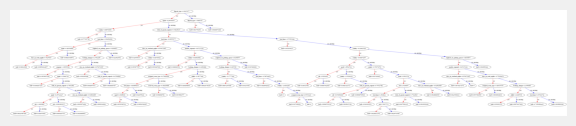

In [177]:
plot_tree(best_model); plt.show()

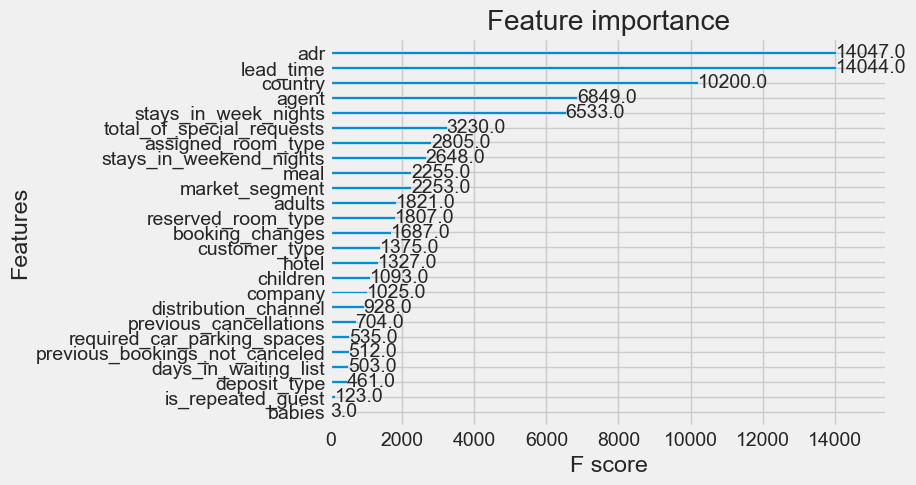

In [178]:
plot_importance(best_model); plt.show()

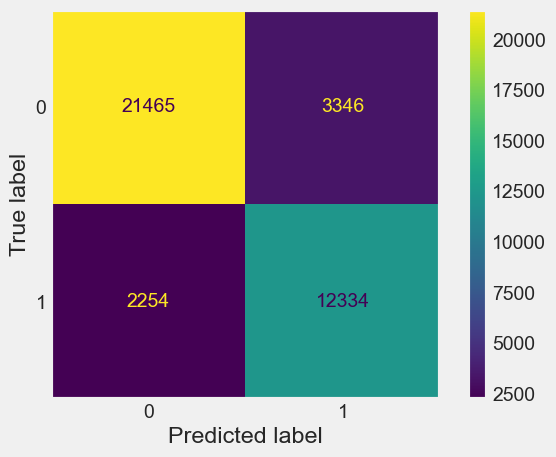

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.style.use('fivethirtyeight')

cm = confusion_matrix(y_test, xgb_preds_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(False)
plt.show()

In [72]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

SCORE:                                                
-0.7473102455933811                                   
SCORE:                                                                           
-0.7674242424242425                                                              
SCORE:                                                                           
-0.8056209150326797                                                              
SCORE:                                                                           
-0.7556288450561299                                                              
SCORE:                                                                           
-0.7799607704427796                                                              
SCORE:                                                                           
-0.8062650289205172                                                              
SCORE:                                                                

In [39]:
#Create instance of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
                                       trials.results])]['model']

#Examine model hyperparameters
print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8699229260467689, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              gamma=0.0414495105996005, gpu_id=0, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.025950922885281346, max_bin=444,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=38,
              min_child_weight=82.70715719611351, missing=nan,
              monotone_constraints=None, n_estimators=7340, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=7, ...)


In [40]:
xgb_preds_best = best_model.predict(X_test)
xgb_score_best = mean_squared_error(y_test, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

RMSE_Best_Model: 0.23742786091101464


In [41]:
print(classification_report(y_true=y_test,y_pred=xgb_preds_best))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     24754
           1       0.94      0.90      0.92     14645

    accuracy                           0.94     39399
   macro avg       0.94      0.94      0.94     39399
weighted avg       0.94      0.94      0.94     39399



In [109]:
original_model = XGBClassifier()
original_model.load_model('xgb_classifier_1.json')
original_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9721661982066598, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='rmse',
              feature_types=['float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'float', 'float', 'float',
                             'float...
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07607419086883228, max_bin=313,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=40,
              min_child_weight=1.735738548025246, missing=nan,
              monotone_constraints=None, n_estimators=4210, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [110]:
import xgboost as xgb
mean_squared_error(y_test, original_model.predict(X_test), squared=False)

0.21003046145972082

In [111]:
print(classification_report(y_true=y_test,y_pred=original_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     24754
           1       0.95      0.93      0.94     14645

    accuracy                           0.96     39399
   macro avg       0.96      0.95      0.95     39399
weighted avg       0.96      0.96      0.96     39399



In [115]:
par_list = original_model.get_params()

['float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float']

In [118]:
del par_list['feature_types']
par_list

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9721661982066598,
 'early_stopping_rounds': 100,
 'enable_categorical': False,
 'eval_metric': 'rmse',
 'gamma': 0.06600034698219365,
 'gpu_id': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.07607419086883228,
 'max_bin': 313,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 13,
 'max_leaves': 40,
 'min_child_weight': 1.735738548025246,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 4210,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': 0.062350648925975416,
 'reg_lambda': 149.61342574149896,
 'sampling_method': 'gradient_based',
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parame

In [121]:
best_base_model = XGBClassifier()
best_base_model.set_params(**par_list)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9721661982066598, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              gamma=0.06600034698219365, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07607419086883228, max_bin=313,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=40,
              min_child_weight=1.735738548025246, missing=nan,
              monotone_constraints=None, n_estimators=4210, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [123]:
# Save a copy of the original best model with its hyperparameters only
import joblib
joblib.dump(best_base_model, 'best_base_model_parameters.json')

['best_base_model_parameters.json']

In [140]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
pipe = ('feature_selection', RFECV(estimator=RandomForestClassifier(n_jobs=-1)),
        'model', XGBClassifier())

In [143]:
# Set up a Hyperopt Function for selecting an optimal number of features
def feature_selector(space):
    rfe.set_params(**space)
    evaluation = [(X_train, np.ravel(y_train)), (X_test, np.ravel(y_test))]
    rfe.fit(X_train, np.ravel(y_train))
    preds = rfe.predict(X_test)
    loss = -f1_score(y_true=np.ravel(y_test), y_pred=preds)
    print ("SCORE:", loss)

    #Specify what the loss is for each model.
    return {'loss': loss, 'status': STATUS_OK, 'model': rfe.estimator}

feature_space = {'min_features_to_select': scope.int(hp.uniform('min_features_to_select', 5, 29))}

# Set up Hyperopt search
trials = Trials()
features_to_select = fmin(feature_selector, feature_space, algo=tpe.suggest, max_evals=30, trials=trials)

print(features_to_select)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

job exception: This RFECV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.



  0%|          | 0/30 [00:23<?, ?trial/s, best loss=?]


NotFittedError: This RFECV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [144]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
def fit_model(params, dtrain, num_boost_round, early_stopping_rounds, nfold, seed):
    # Perform cross-validation with XGBoost
    cv_results = xgb.cv(params=params,
                        dtrain=dtrain,
                        num_boost_round=num_boost_round,
                        early_stopping_rounds=early_stopping_rounds,
                        nfold=nfold,
                        seed=seed,
                        verbose_eval=10,
                        metrics='auc')

    # Get the best number of boosting rounds
    best_nrounds = cv_results.shape[0]

    # Train the final model on all the training data
    model = xgb.train(params=params,
                      dtrain=dtrain,
                      num_boost_round=best_nrounds)

    return model

In [146]:
def feature_selector(params):
    clf = fit_model(params=params, dtrain=dtrain, num_boost_round=1000, early_stopping_rounds=10, nfold=5, seed=42)
    score = -xgb.cv(params=params, dtrain=dtrain, metrics='auc', nfold=5)['test-auc-mean'].max()
    return {'loss': score, 'status': STATUS_OK, 'model': clf}

In [157]:
feature_space = best_model.get_params()
feature_space.update({'eval_metric': 'auc'})
del feature_space["n_estimators"]
del feature_space["early_stopping_rounds"]
del feature_space["enable_categorical"]
del feature_space["missing"]
feature_space

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8699229260467689,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': 0.0414495105996005,
 'gpu_id': 0,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.025950922885281346,
 'max_bin': 444,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 11,
 'max_leaves': 38,
 'min_child_weight': 82.70715719611351,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 7,
 'reg_alpha': 0.2685764444593115,
 'reg_lambda': 13.969330558177631,
 'sampling_method': 'gradient_based',
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None}

In [158]:
features_to_select = fmin(feature_selector, feature_space, algo=tpe.suggest, max_evals=30, trials=trials)

print(features_to_select)

[0]	train-auc:0.88107+0.00462	test-auc:0.87782+0.00488
[10]	train-auc:0.92136+0.00126	test-auc:0.91753+0.00155
[20]	train-auc:0.92743+0.00090	test-auc:0.92362+0.00076
[30]	train-auc:0.93412+0.00029	test-auc:0.93030+0.00046
[40]	train-auc:0.93795+0.00026	test-auc:0.93399+0.00048
[50]	train-auc:0.94280+0.00021	test-auc:0.93882+0.00016
[60]	train-auc:0.94565+0.00028	test-auc:0.94165+0.00026
[70]	train-auc:0.94826+0.00030	test-auc:0.94417+0.00022
[80]	train-auc:0.95030+0.00020	test-auc:0.94611+0.00034
[90]	train-auc:0.95298+0.00026	test-auc:0.94872+0.00043
[100]	train-auc:0.95439+0.00028	test-auc:0.95007+0.00044
[110]	train-auc:0.95603+0.00021	test-auc:0.95165+0.00043
[120]	train-auc:0.95715+0.00025	test-auc:0.95270+0.00039
[130]	train-auc:0.95861+0.00019	test-auc:0.95405+0.00045
[140]	train-auc:0.95985+0.00023	test-auc:0.95518+0.00046
[150]	train-auc:0.96151+0.00027	test-auc:0.95676+0.00046
[160]	train-auc:0.96268+0.00021	test-auc:0.95783+0.00037
[170]	train-auc:0.96363+0.00035	test-auc:0

KeyboardInterrupt: 

In [42]:
best_model.save_model('xgb_standard_classifier.json')

In [35]:
polynomial_data = pd.read_parquet('encoded_data_v3.parquet.gzip')

In [36]:
X_encoded_v3 = polynomial_data.drop(columns=['is_canceled'])
X_train, X_test, y_train, y_test = train_test_split(X_encoded_v3, y, test_size=0.33, random_state=42)

444.0

In [42]:
best['max_bin'] = int(best['max_bin'])
best['max_depth'] = int(best['max_depth'])
best['max_leaves'] =int(best['max_leaves'])
best['n_estimators'] = int(best['n_estimators'])
best_model_copy = XGBClassifier(**best)

In [47]:
evaluation = [(X_train, y_train), (X_val, y_val)]
#Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
best_model_copy.fit(X_train, y_train, eval_set = evaluation, verbose = True)
#Obtain prediction and log_loss score.
new_pred = best_model_copy.predict(X_test)
loss = mean_squared_error(y_test, new_pred)
print ("SCORE:", loss)

In [49]:
print(classification_report(y_test, new_pred))

In [81]:
best_model_copy.feature_importances_

array([0.        , 0.00025442, 0.00018517, ..., 0.        , 0.00204178,
       0.        ], dtype=float32)

In [82]:
best_model.feature_importances_

array([0.0290439 , 0.00821379, 0.00625934, 0.00687779, 0.00927146,
       0.00678124, 0.00165781, 0.13170686, 0.02833876, 0.04578819,
       0.00826106, 0.01094193, 0.1622147 , 0.07233153, 0.01475453,
       0.01016071, 0.        , 0.01760121, 0.02125422, 0.02538181,
       0.01736617, 0.0110823 , 0.05226507, 0.02405405, 0.0251057 ,
       0.04635749, 0.01917743, 0.00897653, 0.1787744 ], dtype=float32)

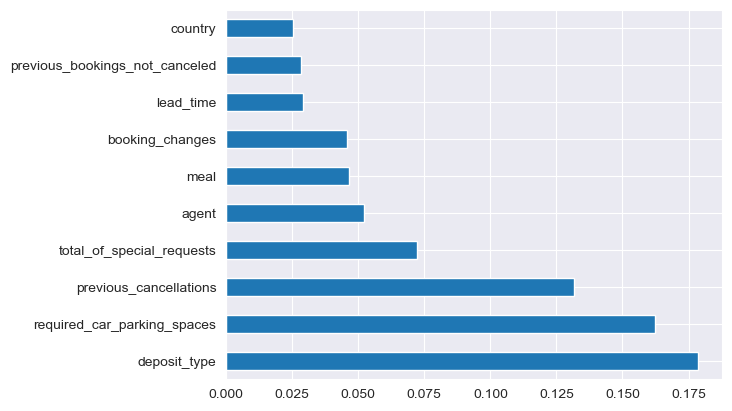

In [84]:
feat_importances = pd.Series(best_model.feature_importances_, index = best_model.feature_names_in_)
feat_importances.nlargest(10).plot(kind='barh');

In [127]:
ica_data = pd.read_parquet('ica_data.parquet.gzip')
best_model_copy_ica = XGBClassifier(**best)
X_ica = ica_data.drop(columns=['is_canceled'])
X_train, X_test, y_train, y_test = train_test_split(X_ica, y, test_size=0.33, random_state=42)

In [128]:
evaluation = [(X_train, y_train), (X_test, y_test)]
#Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
best_model_copy.fit(X_train, y_train, eval_set = evaluation, verbose = False)
#Obtain prediction and log_loss score.
new_pred = best_model_copy.predict(X_test)
loss = mean_squared_error(y_test, new_pred,squared=False)
print ("SCORE:", loss)

SCORE: 0.2628943310055481


In [196]:
pred_probs = pd.DataFrame(best_model_copy.predict_proba(X_test), columns = ['prob_0', 'prob_1'])
pred_probs['prediction_with_prob'] = pred_probs.prob_1.apply(lambda x: 0 if x <= 0.465 else 1)

In [148]:
print(classification_report(y_true=y_test, y_pred=new_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     24754
           1       0.95      0.86      0.90     14645

    accuracy                           0.93     39399
   macro avg       0.94      0.92      0.92     39399
weighted avg       0.93      0.93      0.93     39399



In [197]:
print(classification_report(y_true=y_test, y_pred=pred_probs.prediction_with_prob))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     24754
           1       0.94      0.87      0.90     14645

    accuracy                           0.93     39399
   macro avg       0.93      0.92      0.93     39399
weighted avg       0.93      0.93      0.93     39399



In [191]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true=y_test, y_pred=new_pred))
tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=new_pred).ravel()
tn, fp, fn, tp

[[24109   645]
 [ 2078 12567]]


(24109, 645, 2078, 12567)

In [198]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true=y_test, y_pred=pred_probs.prediction_with_prob))
tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=pred_probs.prediction_with_prob).ravel()
tn, fp, fn, tp

[[23949   805]
 [ 1881 12764]]


(23949, 805, 1881, 12764)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.33, random_state=42)

In [123]:
lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.999999999, tol=0.000000001, max_iter=50000, n_jobs=-1)
lr.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test, lr.predict(X_test)))

In [125]:
best_model_copy_ica.predict_proba()

NotFittedError: need to call fit or load_model beforehand

In [4]:
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope
# Define the hyperparameter search space
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 1000, 10)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 30, 1)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}
# Define the objective function to minimize
def objective(params):
    clf = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(clf, X_standard, y, cv=5, n_jobs=-1).mean()
    return -score

# Run the hyperparameter search using Tree-structured Parzen Estimator (TPE) algorithm
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, rstate=np.random.default_rng(42))

# Train a model using the best hyperparameters found
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_standard, y)

  0%|          | 0/30 [00:18<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [18]:
best_params

{'max_depth': 23.0,
 'max_features': 2,
 'min_samples_leaf': 0.135540739226335,
 'min_samples_split': 0.5204337092518656,
 'n_estimators': 80.0}

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
best_clf = RandomForestClassifier(max_depth=23, max_features=2, n_estimators=80, min_samples_leaf=0.135540739226335,
                                  min_samples_split=0.5204337092518656, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_robust, y, test_size=0.33, random_state=42)
best_clf.fit(X_train, y_train)
print(classification_report(y_test, best_clf.predict(X_test), labels = [0,1]))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77     24754
           1       0.00      0.00      0.00     14645

    accuracy                           0.63     39399
   macro avg       0.31      0.50      0.39     39399
weighted avg       0.39      0.63      0.48     39399



C:\Users\fight\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fight\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fight\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
set(y_test) - set(best_clf.predict(X_test))

{1}

In [70]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from sklearn.metrics import precision_score, r2_score, mean_squared_error
# Define hyperparameter space
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10))
}

# Define objective function
def objective(params):
    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
    return {'loss': -rmse, 'status': STATUS_OK}

# Split data into training and testing sets
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X_robust, y, test_size=0.33, random_state=42)

# Define trials object and run hyperparameter search
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

# Print best hyperparameters and accuracy
print("Best hyperparameters:", best)
best_params = space_eval(space, best)
clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("R2:", r2_score(y_test, y_pred))

  0%|          | 0/30 [00:01<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test, y_pred))

In [62]:
X_standard = X_standard.drop('reservation_status', axis=1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size= 0.35, random_state=1352)
clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("R2:", r2_score(y_test, y_pred))

R2: 0.06772310072822618


In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85     26217
           1       0.94      0.44      0.60     15570

    accuracy                           0.78     41787
   macro avg       0.84      0.71      0.73     41787
weighted avg       0.82      0.78      0.76     41787



In [45]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred)}")


R2 Score: 0.9992834151427581


In [47]:
print(precision_score(y_test, y_pred))

1.0


In [48]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [49]:
y_test

99421     0
18436     0
27430     0
113582    0
111001    0
         ..
32450     0
52759     1
84560     0
27250     0
85486     0
Name: is_canceled, Length: 41787, dtype: int64

In [50]:
print(precision_score(y_train, clf.predict(X_train)))

1.0


In [51]:
data = pd.read_parquet('combined_data_basic.parquet.gzip')
X_train, X_test, y_train, y_test = train_test_split(data.drop('is_canceled', axis=1), data.is_canceled, test_size= 0.35, random_state=1352)
clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("R2:", r2_score(y_test, y_pred))

R2: 0.9992834151427581


In [54]:
from tqdm import tqdm
from sklearn.model_selection import RepeatedStratifiedKFold
X = data.drop('is_canceled', axis=1)
y = data.is_canceled
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
clf = RandomForestClassifier(**best_params)
scores = tqdm(cross_val_score(clf, X, y, cv=rskf))

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())

KeyboardInterrupt: 

In [58]:
data_v2 = pd.read_parquet('encoded_data_v2.parquet.gzip')
X_train, X_test, y_train, y_test = train_test_split(data_v2.drop('is_canceled', axis=1), data_v2.is_canceled, test_size= 0.35, random_state=1352)
clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("R2:", r2_score(y_test, y_pred))

R2: 0.0032304635764509593


In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     26217
           1       0.97      0.39      0.55     15570

    accuracy                           0.77     41787
   macro avg       0.85      0.69      0.70     41787
weighted avg       0.82      0.77      0.73     41787



In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26217
           1       1.00      1.00      1.00     15570

    accuracy                           1.00     41787
   macro avg       1.00      1.00      1.00     41787
weighted avg       1.00      1.00      1.00     41787



# With simple one hot encoding

In [179]:
data = pd.read_csv('hotel_bookings.csv')
data = data.fillna(0)
data = data.drop(['reservation_status', 'reservation_status_date'], axis=1)

In [180]:
data.agent = data.agent.astype('object')
data.company = data.company.astype('object')

In [118]:
date_cols = [col for col in data.columns if col.__contains__('date')]
date_cols

['arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month']

In [119]:
data = data.drop(date_cols, axis=1)

In [120]:
data.agent = data.agent.astype('object')
data.company = data.company.astype('object')
cat_cols = [col for col in data.columns if data[col].dtype in ['object']]
cat_cols

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'agent',
 'company',
 'customer_type']

In [108]:
cat_data = pd.DataFrame(data[cat_cols])
cat_data = pd.get_dummies(cat_data)

C:\Users\fight\AppData\Local\Temp\ipykernel_110780\3215117462.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat_data = pd.get_dummies(cat_data)
C:\Users\fight\AppData\Local\Temp\ipykernel_110780\3215117462.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat_data = pd.get_dummies(cat_data)


In [109]:
data = data.drop(cat_cols, axis=1)
data = pd.concat([data, pd.DataFrame(cat_data)], axis=1)

In [110]:
X_t, X_te, y_t, y_te = train_test_split(data.drop('is_canceled', axis=1), data.is_canceled, test_size=0.33)

In [113]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_t, y_t)

RandomForestClassifier(n_jobs=-1)

In [114]:
pr = rf.predict(X_te)
print(classification_report_with_scores(y_te, pr))


Accuracy: 0.885
False Positive Rate: 0.068
False Negative Rate: 0.195
Precision: 0.876
Recall: 0.805
RMSE:0.339
F1-Score:0.839
F2-Score:0.818
ROC_AUC_Score:0.868
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     24714
           1       0.88      0.80      0.84     14685

    accuracy                           0.88     39399
   macro avg       0.88      0.87      0.87     39399
weighted avg       0.88      0.88      0.88     39399



In [124]:
data[cat_cols] = data[cat_cols].astype('category')

In [136]:
from sklearn.preprocessing import LabelBinarizer
for col in cat_cols:
    lb = LabelBinarizer()
    lb_results = lb.fit_transform(data[col])
    lb_columns = [f"{col}_{c}" for c in enumerate(lb.classes_)]
    lb_data = pd.DataFrame(lb_results, columns=lb_columns)
    data = pd.concat([data, lb_data], axis=1)
    data = data.drop(col, axis=1)

ValueError: Shape of passed values is (119390, 1), indices imply (119390, 2)

In [140]:
lb.y_type_

'binary'

In [132]:
for c in lb.classes_:
    print(c)

City Hotel
Resort Hotel


In [141]:
data.shape

(119390, 26)

In [142]:
cat_cols

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'agent',
 'company',
 'customer_type']

In [143]:
ordinal_data = data[cat_cols]
ordinal_data = ordinal_data[['meal', 'reserved_room_type', 'assigned_room_type', 'deposit_type']]
grouped = ordinal_data.groupby('reserved_room_type').count().sort_values(by = 'meal', ascending=False).index
room_order = [_ for _ in grouped]
# re-level the data for reserved room types
ordinal_data.reserved_room_type = ordinal_data.reserved_room_type.cat.reorder_categories(room_order, ordered = True)

ordinal_data.head()

,meal,reserved_room_type,assigned_room_type,deposit_type
0,BB,C,C,No Deposit
1,BB,C,C,No Deposit
2,BB,A,C,No Deposit
3,BB,A,A,No Deposit
4,BB,A,A,No Deposit


In [144]:
room_order

['A', 'D', 'E', 'F', 'G', 'B', 'C', 'H', 'P', 'L']

In [148]:
ordinal_data['is_canceled'] = data.is_canceled.copy()

In [163]:
# room bookings by type plot
room_types = ordinal_data.groupby('reserved_room_type')['is_canceled'].sum()


In [166]:
room_types = pd.DataFrame(room_types)

,is_canceled
reserved_room_type,
A,33630
D,6102
E,1914
F,880
G,763
B,368
C,308
H,245
P,12


In [168]:
room_types['bookings'] = ordinal_data.groupby('reserved_room_type')['is_canceled'].count()
room_types.head(10)

,is_canceled,bookings
reserved_room_type,,
A,33630,85994
D,6102,19201
E,1914,6535
F,880,2897
G,763,2094
B,368,1118
C,308,932
H,245,601
P,12,12


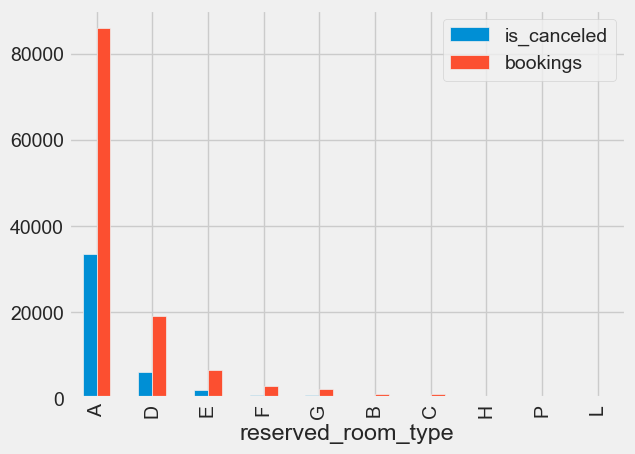

In [170]:
room_types.plot(kind = 'bar')
plt.show()